### Python scripts to generate all figures and tables presented in Hemingway and Henkes (2021) "A disordered kinetic model for clumped isotope bond reordering in carbonates"

All calculations are performed using the 'isotopylog' python package, which can be found at: http://pypi.python.org/pypi/isotopylog

### Load packages and import data

Data for all experiments is contained in Table S.1. Here, we use ∆47 values in the CDES90 reference frame of Bonifacie et al. (2017).

In [1]:
#load pacakges
import isotopylog as ipl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#deal with pdf backend font issue
from matplotlib import rc
plt.rcParams['pdf.fonttype'] = 42


#import data
file = 'all_data_import.csv' #Table S1 converted to csv format
"""
The first column (0) is the order of experiemnt
The second column (1) is the time sequence (seconds)
"""
dftot = pd.read_csv(file, index_col = [0,1])

kink_file = 'kinks.csv' #list telling which kinks to use for L curve
"""
Here, "index_col = 0" means just load the unique ID of the kinetic parameter
"""
kinks = pd.read_csv(kink_file, index_col = 0)

rw_file = 'random_walk_cluster_results.csv' #random walk cluster run output
rw = pd.read_csv(rw_file)

#drop data to cull
drop_ind = dftot[dftot['cull'] == True].index

try:
    dftot.drop(drop_ind, inplace = True)
except ValueError: #already dropped
    pass

#add necessary columns:

#all in CDES90 ref frame
dftot['ref_frame'] = 'CDES90'

#all use Gonfiantini iso params except Lloyd, who uses Brand
dftot['iso_params'] = 'Gonfiantini'
li = dftot[dftot['reference'] == 'Lloyd et al. (2018)'].index
dftot.loc[li, 'iso_params'] = 'Brand'

### Table S3

Resulting statistics of regularized inverse (rmse, roughness norm, $\omega$) and lognormal (rmse, $\mu_\nu$, $\sigma_\nu$) model fits for all heating experiments used in this study, both from the literature compilation and new experiments presented here. The non-negativity constraint was relaxed for aragonite experiments [i.e., $r(\lambda)$ was fit]; thus, only regularized inverse model fit statistics are included for these experiments.

In [2]:
#drop experiments with only 3 data points
gr = dftot.groupby(level = 0).size()
ind = gr[gr!=3].index

dftot = dftot.loc[ind,:]

#determine how many experiments exist
exp_list = list(set(dftot.index.get_level_values(0)))
# exp_list = [1,2,3,4]

calfunc = 'Bea17'
#make calibration lambda function for comparing to Lloyd equation
# calfunc = lambda T : -3.4075e9/T**4 + 2.3655e7/T**3 - 2.6317e3/T**2 - 5.8537/T + 0.176

#make dataframe to store statistics results
cols = ['T_C',
        'sample_id',
        'mineralogy',
        'reference',
        'mu_nu',
        'sig_nu',
        'mu_std',
        'sig_std',
        'rmse',
        'res_inv',
        'rgh_inv',
        'omega',
        'SN',
        'npt'
       ]

resdf = pd.DataFrame(index = exp_list, columns = cols)

#make dictionary containing each kdistribution object for generating EDistributions later
kddict = {}

#set constants
nu_min = -60
nu_max = 30

for exp in exp_list:
    
    #make figure for plotting
    fig, ax = plt.subplots(1,3,
        figsize = (12, 4)
        )

    #extract data
    df = dftot.xs(exp, level = 'exp', drop_level = True).reset_index()

    #see if aragonite and, if so, relax non-negativity constraint
    if (df['mineralogy'] == 'Aragonite').any() is True:
        non_neg = False
    else:
        non_neg = True
    
    #fit model:
    #make heatingexperiment object
    he = ipl.HeatingExperiment.from_csv(
        df, 
        calibration = calfunc,
        culled = False #culled manually above, if necessary
        )
    
    #calculate L curve
    om_best, _ = ipl.calc_L_curve(
        he,
        ax = ax[1],
        nu_min = nu_min,
        nu_max = nu_max,
        omega_min = 0.1,
        omega_max = 100,
        plot = True,
        kink = kinks.loc[exp,'kink'],
        )
    
    #make kdistribution object
    kd = ipl.kDistribution.invert_experiment(
        he,
        model = 'HH20',
        fit_reg = True,
        non_neg = non_neg,
        nu_min = nu_min,
        nu_max = nu_max,
        omega = om_best
        )
    
    #store kd in dictionary
    kddict[exp] = kd
    
    #forward model
    he.forward_model(kd)
    
    #plot data
    he.plot(
        ax = ax[0], 
        yaxis = 'D',
        plot_reg = True,
        logy = False
        )
    
    kd.plot(
        ax = ax[2],
        )
    
    #store figure
    plt.tight_layout()
    
    name = str(df['sample_id'][0])+'_'+str(df['T_C'][0])+'_'+str(df['reference'][0])
    fig.savefig('output_figures/experiment_plots/HH20/'+name+'.pdf',
        transparent = True,
        bbox_inches = None,
        )
    
    #close figures
    plt.close('all')
    
    #calculate signal to noise
    SN = (he.dex[:,0].max() - he.dex[:,0].min())/he.dex_std[:,0].mean()
    
    #store information in dataframe
    resdf.loc[exp,'T_C'] = he.T - 273.15
    resdf.loc[exp,'sample_id'] = df['sample_id'][0]
    resdf.loc[exp,'mineralogy'] = df['mineralogy'][0]
    resdf.loc[exp,'reference'] = df['reference'][0]
    resdf.loc[exp,['mu_nu','sig_nu']] = kd.params
    resdf.loc[exp,['mu_std','sig_std']] = np.sqrt(np.diag(kd.params_cov))
    resdf.loc[exp,'rmse'] = kd.rmse
    resdf.loc[exp,'res_inv'] = kd.res_inv
    resdf.loc[exp,'rgh_inv'] = kd.rgh_inv
    resdf.loc[exp,'omega'] = om_best
    resdf.loc[exp,'SN'] = SN
    resdf.loc[exp,'npt'] = len(he.dex)
    

resdf.to_csv('output_tables/Table_S3.csv')
# resdf.to_csv('output_tables/Table_S3_LloydEquation.csv')

/usr/local/lib/python3.7/site-packages/isotopylog-0.0.4-py3.7.egg/isotopylog/core_functions.py:79: RuntimeWarning: divide by zero encountered in true_divide
  dndd = np.gradient(num)/np.gradient(denom)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1057: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:1078: RuntimeWarning: invalid value encountered in double_scalars
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/usr/local/lib/python3.7/site-packages/isotopylog-0.0.4-py3.7.egg/isotopylog/ratedata_helper.py:247: RuntimeWarning: invalid value encountered in true_divide
  k = np.abs(dy2d2x / ((1 + dydx**2)**1.5))
/usr/local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:73: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/usr/local/lib/python3.7/site-pa

### Table 1

Arrhenius regression activation energy distribution results (Eq. 27) for individual calcite and dolomite sample materials and for the "all calcite" average. Experiments exhibiting noisy data [i.e., $\Delta_{47}(t)$ signal-to-noise $< 5$] or non-monotonic $\Delta_{47}(t)$ evolution were excluded from these calculations (see Sec. 4.3 and Table S.3). Sample materials are only included here if $\geq 3$ experiments were retained after this screening procedure. OC = optical calcite; BC = brachiopod shell calcite; SC = spar calcite; D = dolomite; WHP = wet, high-pressure experiments; $n$ = number of experiments included in Arrhenius regression.

In [3]:
#reload resdf so we don't have to re-calculate inversions every time
# resdf = pd.read_csv('output_tables/Table_S3.csv', index_col = 0)
resdf = pd.read_csv('output_tables/Table_S3_LloydEquation.csv', index_col = 0)

#make empty data frame
sam_cts = resdf.groupby('sample_id')['T_C'].count()
sams = sam_cts[sam_cts > 2].index

cols = ['muE_mean', 
        'muE_std',
        'lnk0_mean',
        'lnk0_std',
        'sigE_mean', 
        'sigE_std', 
        'n']

sam_Es = pd.DataFrame(index = sams, columns = cols)

#loop through each sample and calculate
for sam in sams:
    
    #extract samples of a given sample type
    c = resdf[resdf['sample_id'] == sam].index.values

    #make lists of kd objects
    sam_kds = [kddict[i] for i in c]

    #make ED objects
    sam_ED = ipl.EDistribution(sam_kds)
    
    #store resulting statistics
    sam_Es.loc[sam, 'muE_mean'] = sam_ED.Eparams[0,0]
    sam_Es.loc[sam, 'sigE_mean'] = -sam_ED.Eparams[0,1]
    sam_Es.loc[sam, 'lnk0_mean'] = sam_ED.Eparams[1,0]
    
    sam_Es.loc[sam, 'muE_std'] = sam_ED.Eparams_cov[0,0]**0.5
    sam_Es.loc[sam, 'sigE_std'] = sam_ED.Eparams_cov[2,2]**0.5
    sam_Es.loc[sam, 'lnk0_std'] = sam_ED.Eparams_cov[1,1]**0.5
    
    sam_Es.loc[sam, 'n'] = sam_ED.npt
    

#save table
sam_Es.to_csv('output_tables/Table_1.csv')
# sam_Es.to_csv('output_tables/Table_1_LloydEquation.csv')

### Figure 1

Crystal structures of (\textbf{A}) calcite and (\textbf{B}) aragonite, each showing two unit cells projected onto the (001) plane. Carbon (grays), oxygen (reds), and calcium (greens) atoms are shaded according to their distance along the $c$ axis. Isotopically substituted oxygens ($^{18}O$) and carbons ($^{13}C$) are shown in gold and blue, respectively. Also included are representations of crystal lattice defects that may influence oxygen bonding environments and clumped isotope reordering rates: calcium substitutions (e.g., $Mg^{2+}$ or $Sr^{2+}$; purple), oxygen vacancies (open circles), and interstitial atoms (hexagons). Interactions between an $^{18}O$ atom and neighboring defects are highlighted with pink lines, whereas bond distances (in Angstroms) between an $^{18}O$ atom and all nearest neighbor O atoms are highlighted with light blue lines (Markgraff, 1985; de Villiers, 1971). For aragonite, O1 type oxygens are outlined in white, whereas O2 type oxygens are outlined in black. Dolomite crystal structure is similar to that of calcite but with the $c/6$ calcium replaced by magnesium.

(Figure made outside of python)

### Figure 2

The random walk bond reordering model: (\textbf{A}) Potential energy wells for oxygen atoms vibrating about their zero-point energies (ZPE; thick gold lines) in two neighboring \ce{CO3} groups. At the molecular level, diffusion occurs when an oxygen atom "jumps" from one $CO_3$ group $i$ to a neighboring group $j$ (blue dotted line); a jump requires that the activation energy barrier $E_{i,j}$ is overcome. If an $^{18}O$ atom (gold circle) jumps to a neighboring $^{13}C$-containing group (blue circle), then the ZPE of the resulting clump is lower than that for the initial state and the reaction is thermodynamically favored. (\textbf{B}) Conceptual diagram of the model setup. A grid of $n_C$ carbon atoms is created, each with a random probability of being isotopically substituted (blue circles) that is equal to the natural abundance of $^{13}C$ (assumed $\delta^{13}C = 0$ ‰). An $^{18}O$ atom (gold circle) is then "seeded" onto the grid; $r_i$, the probability of initially being associated with carbon atom $i$, follows a uniform distribution but is increased by a factor of $R^{47, 0}/R^{*47}$, the initial $\Delta_{47}$ value, for all $^{13}C$ atoms. At each time step $t_k$, the $^{18}O$ atom can "jump" to any of its neighboring carbon atoms with a total probability $p$ such that $p = \sum q_{i,j}$, where $q_{i,j}$ is the probability of jumping to neighboring carbon atom $j$; $q_{i,j}$ decreases as the square of the distance between the two carbon atoms and is increased by a factor of $R^{47, \text{eq}}/R^{*47}$, the equilibrium $\Delta_{47}$ value, for all neighboring $^{13}C$ atoms. An example random walk is shown with the dotted gold (no clump formed at $t_k$) and blue (clump formed at $t_k$) trajectory. The random walk process is repeated $n_O$ times for a given carbon grid; uncertainty is determined by recreating the carbon grid $n_\text{iter}$ times for a total of $n_O \times n_\text{iter}$ random walks. (\textbf{C}) Model results showing $G(t_k)$, the normalized deviation from equilibrium at each time step, as a function of $\langle J \rangle$, the ensemble averaged number of jumps per $^{18}O$ atom. $\langle J \rangle = pt_k$ is nondimensional time such that  $\langle J \rangle = 1$ is the mean life of an exponential decay reaction with rate constant $k = p$ (dotted black line). The model shown here (blue line and shaded region) was initialized with $d_{i,j}$ for calcite (see Fig. 1), $R^{47, 0}/R^{*47} = 1.01$, $R^{47, \text{eq}}/R^{*47} = 1.0025$, $p = 0.1$, $n_C = 10^4$, $n_O = 10^6$, $n_\text{iter} = 10^3$, and $n_t = 25$. Also shown is the predicted $G(t_k)$ evolution using the best-fit lognormal disordered kinetics solution (solid black line).

(Panels A and B made outside of python)

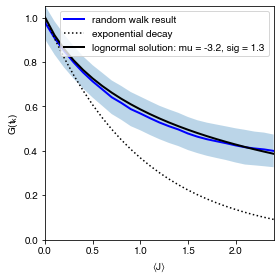

In [4]:
#make figure
fig2, ax2 = plt.subplots(1,1,
    figsize = (4,4)
    )

#set inputs
p = 0.1 #jump probability
t = rw['tk']

#plot results
rw.columns
ax2.plot(p*t, rw['G_mean'],
    'b',
    linewidth = 2,
    label = 'random walk result'
    )

ax2.fill_between(p*t, rw['G_mean']-rw['G_std'], rw['G_mean']+rw['G_std'],
    alpha = 0.3
    )

#include exponential decay line
ax2.plot(p*t, np.exp(-p*rw['tk']),
    ':k',
    label = 'exponential decay'
    )

#make line for best-fit lognormal solution to random-walk results
mu = -3.16 #best-fit mu
sigma = 1.27 #best-fit sigma


nu = np.linspace(-15,5,150)

pnu = ipl.ratedata_helper._Gaussian(nu, mu, sigma)
A = ipl.ratedata_helper._calc_A(t,nu)
Ghat = np.inner(A,pnu)

#include lognormal solution line
lab = 'lognormal solution: mu = %.1f, sig = %.1f' %(mu, sigma)
ax2.plot(p*t, Ghat,
    'k',
    linewidth = 2,
    label = lab
    )

#set labels and limits
ax2.set_xlabel(r'$\langle J \rangle$')
ax2.set_ylabel(r'$G(t_k)$')

ax2.set_xlim([0,2.4])
ax2.set_ylim([0,1.05])

ax2.legend(loc = 'best')

plt.tight_layout()
plt.show()

# Save figure
fig2.savefig('output_figures/Fig_2.pdf',
    transparent = True,
    bbox_inches = None,
    )

### Figure 3

Examples of the disordered kinetic model for optical calcite (MBG-CC-1) isotopologue reordering experiments performed at (\textbf{top}) $385$, (\textbf{middle}) $425$, and (\textbf{bottom}) $475$ C (data from Passey and Henkes 2012 EPSL). Panels (\textbf{A}), (\textbf{D}), and (\textbf{G}) show the Tikhonov regularization L-curve for each experiment (solid black line), including the best-fit $\omega$ value (gray circle). Panels (\textbf{B}), (\textbf{E}), and (\textbf{H}) show the pdf of $\nu$ for each experiment, including the best-fit regularized inverse solution (dotted black line) and the lognormal solution (solid blue line). Panels (\textbf{C}), (\textbf{F}), and (\textbf{I}) show the measured $\Delta_{47}$ values and the modeled $\Delta_{47}$ evolution as predicted by the best-fit regularized inverse solution (dotted black line) and the lognormal solution (solid blue line).  Shaded blue region is the propagated $\pm 1\sigma$ uncertainty of the lognormal solution. For reference, reaction progress for each experiment is also shown by converting $\Delta_{47}$ to $G(t)$. The observed left-skewed regularized inverse solution at lower temperature and right-skewed regularized inverse solution at higher temperature is a general feature of most experiments included in this study (Section \ref{Sec:5}). rgh = roughness; rmse = root mean square error, min = minutes.

Experiment 1 log(rmse) = -2.153
Experiment 3 log(rmse) = -2.065
Experiment 5 log(rmse) = -1.988


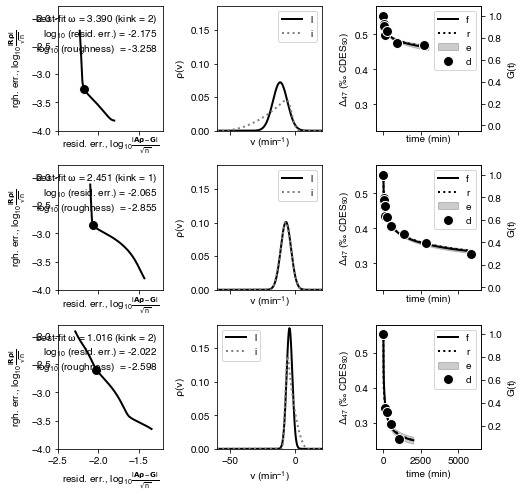

In [5]:
#make figure
fig3, ax3 = plt.subplots(3,3, 
    figsize = (7.48, 7),
    sharex = 'col',
    sharey = 'col',
    )

#determine which experiments to plot
exps = [1,3,5]

#set constants
nu_min = -60
nu_max = 20
rn_ylim = [0, 0.185]

for i, exp in enumerate(exps):

    #extract data
    df = dftot.xs(exp, level='exp', drop_level = True).reset_index()

    #fit model:
    #make heatingexperiment object
    he = ipl.HeatingExperiment.from_csv(
        df, 
        culled = False #culled manually above, if necessary
        )

    #plot L curve:
    #define L curve stylistic dictionaries
    ld = {'linewidth':2,'color':'k'}
    ptd = {'marker':'o','s':100,'c':'k','edgecolor':'w'}

    #plot L curve data
    om_best, _ = ipl.calc_L_curve(
        he,
        ax = ax3[i,0],
        nu_min = nu_min,
        nu_max = nu_max,
        omega_min = 0.1,
        omega_max = 100,
        plot = True,
        kink = kinks.loc[exp,'kink'],
        ld = ld,
        pd = ptd
        )
    
    #define L curve limits and labels
    ax3[i,0].set_xlabel(r'resid. err., $log_{10}\frac{\|\mathbf{A\rho} - \mathbf{G} \|}{\sqrt{n}}$')
    ax3[i,0].set_ylabel(r'rgh. err., $log_{10}\frac{\|\mathbf{R\rho} \|}{\sqrt{n}}$')
    
    #make kdistribution object with model fit
    kd = ipl.kDistribution.invert_experiment(
        he,
        model = 'HH20', #for the model presented in this paper
        fit_reg = True,
        nu_min = nu_min,
        nu_max = nu_max,
        omega = om_best,
        )
    
    #print lognormal rmse
    t = 'Experiment %s log(rmse) = %.3f' %(exp, np.log10(kd.rmse))
    print(t)

    #forward model results
    he.forward_model(kd)

    #define kd stylistic dictionaries
    lnd = {'linewidth':2,'color':'k'}
    invd = {'linewidth':2,'color':[0.5,0.5,0.5],'ls':':'}

    #plot kd data
    kd.plot(
        ax = ax3[i,1],
        lnd = lnd,
        invd = invd
        )

    #define kd limits and labels
    ax3[i,1].legend('li') #make a shorter legend for visual clarity
    ax3[i,1].set_xlim([nu_min, nu_max])
    ax3[i,1].set_ylim(rn_ylim)
    ax3[i,1].set_xlabel(r'$\nu$ (min$^{-1}$)')
    ax3[i,1].set_ylabel(r'$\rho(\nu)$')
    
    #set axis limits
    ax3[0,0].set_ylim([-4, -1.8])
    ax3[0,0].set_xlim([-2.5, -1.2])

    ax3[0,2].set_ylim([0.225, 0.58])
    ax3[0,2].set_xlim([-500, 6500])

    #define he stylistic dictionaries
    ed = {'fmt':'o', 'mec':'w','mfc':'k','ms':10,'ecolor':'k'}
    ld = {'linewidth':2,'color':'k'}
    fbd = {'alpha':0.2,'color':'k'}
    regd = {'linewidth':2,'color':'k','ls':':'}

    #plot he data
    he.plot(
        ax = ax3[i,2],
        yaxis = 'D',
        logy = False,
        plot_reg = True,
        ed = ed,
        ld = ld,
        fbd = fbd,
        regd = regd
        )

    #define he limits and labels
    ax3[i,2].legend('fred') #make a shorter legend for visual clarity
    ax3[i,2].set_xlabel('time (min)') #add time units
    ax3[i,2].set_ylabel(r'$\Delta_{47}$ (‰ CDES$_{90}$)') #add D47 units
    
    #twinx plot to add G axis:
    #extract limits
    ylim = np.array(ax3[i,2].get_ylim())
    Deq = he.caleq(he.T)
    D0 = he.dex[0,0]

    #convert limits to G limits and plot
    glim = (ylim - Deq)/(D0-Deq)
    axt = ax3[i,2].twinx()
    axt.set_ylim(glim)
    
    #define labels
    axt.set_ylabel(r'$G(t)$')
    
plt.tight_layout()

# Save figure
fig3.savefig('output_figures/Fig_3.pdf',
    transparent = True,
    bbox_inches = None,
    )

### Figure 4

Example rate distribution results for optical calcite (MBG-CC-1) isotopologue reordering experiments (data from Passey and Henkes, 2012). Best-fit lognormal rate distributions $\rho(\nu)$ are shown for each experimental temperature (see Table S3 for distribution statistics). Distributions generally become narrower and shift toward faster rates with increasing temperature, as predicted by Eq. 27 if isotopologue reordering follows an underlying Gaussian distribution of activation energies.

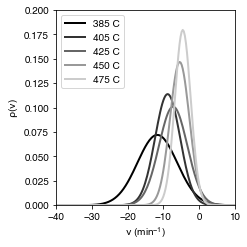

In [6]:
#make figure
fig4, ax4 = plt.subplots(1,1,
    figsize = (3.54, 3.54)
    )

#lognormal pdfs of all experiments at various temperatures for a given sample
sam_type = 'MBG-CC-1'

#extract MBG-CC-1 samples
c = resdf[resdf['sample_id'] == sam_type].index.values

#make lists of kd objects
sam_kds = [kddict[i] for i in c]

#loop through each experiment and plot
for i, kd in enumerate(sam_kds):
    ax4.plot(
        kd.nu, 
        kd.rho_nu,
        c = [i/5, i/5, i/5],
        linewidth = 2,
        label = '%.0f C' %(kd.T-273.15),
        )

#set limits and labels
ax4.set_xlim([-40,10])
ax4.set_ylim([0,.2])
ax4.set_xlabel(r'$\nu$ (min$^{-1}$)')
ax4.set_ylabel(r'$\rho(\nu)$')

#add legend
ax4.legend(loc = 'upper left')

plt.tight_layout()

# Save figure
fig4.savefig('output_figures/Fig_4.pdf',
    transparent = True,
    bbox_inches = None,
    )

### Figure 5

Arrhenius plots showing (\textbf{A}) $\mu_{\nu}$ and (\textbf{B}) $\sigma_{\nu}$ as a function of inverse experimental temperature. Arrhenius regression best-fit lines calculated using Eq. 27 for calcite (solid black line) and dolomite (solid blue line) are also shown, including $\pm 1\sigma$ uncertainty about each regression line (shaded regions). Experiments exhibiting noisy data [i.e., $\Delta_{47}(t)$ signal-to-noise $< 5$] or non-monotonic $\Delta_{47}(t)$ evolution were excluded from regressions and thus are not shown here (see Sec. 4.3 and Table S.3).

calcite: $\mu_E$ = 224.29 $\pm$ 27.60; $\sigma_E$ = 17.44 $\pm$ 0.74; $\nu_0$ = 31.51 $\pm$ 4.58; n = 24
dolomite: $\mu_E$ = 230.25 $\pm$ 47.69; $\sigma_E$ = 14.82 $\pm$ 2.16; $\nu_0$ = 28.95 $\pm$ 6.83; n = 4
calcite Arrhenius plot RMSE: mu_nu = 1.33; sig_nu = 0.89
dolomite Arrhenius plot RMSE: mu_nu = 0.49; sig_nu = 0.57


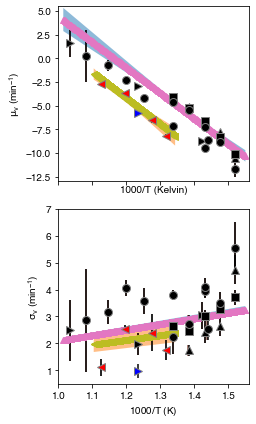

In [7]:
#reload resdf so we don't have to re-calculate inversions every time
resdf = pd.read_csv('output_tables/Table_S3.csv', index_col = 0)
# resdf = pd.read_csv('output_tables/Table_S3_LloydEquation.csv', index_col = 0)

#drop samples: 
# (1) with SN < 5
# (2) aragonite samples
# (3) Lloyd 2018 717C dolomite sample (divide by zero error)
# (4) Stolper 2015 692C apatite sample (values increase with time)
resdf = resdf[resdf['SN'] > 5]
resdf = resdf[resdf['mineralogy'] != 'Aragonite']

try:
    resdf.drop(37, inplace = True)
except KeyError: #already dropped it
    pass

try:
    resdf.drop(26, inplace = True)
except KeyError: #already dropped it
    pass

#make dictionary for mineral-specific plotting styles
mins = set(resdf['mineralogy'])
minsty = {
    'Apatite (carbonate group)':'b',
    'Calcite':'k',
    'Dolomite':'r'
    }

#make dictionary for study-specific plotting styles
refs = set(resdf['reference'])
refsty = {
    'Brenner et al. (2018)':'^',
    'Henkes et al. (2014)':'s',
    'Lloyd et al. (2018)':'<',
    'Passey & Henkes (2012)':'o',
    'Stolper & Eiler (2015)':'>',
    }

#make figure
fig5, ax5 = plt.subplots(2,1,
    sharex = True,
    figsize = (3.54, 6)
    )

#loop through and plot
for m in mins:
    for r in refs:
        
        #extract the data
        d = resdf[resdf['mineralogy'] == m]
        d = d[d['reference'] == r]
        
        #get x axis into right format
        x = 1000/(d['T_C']+273)
        
        #plot mu_nu
        ax5[0].errorbar(
            x,
            d['mu_nu'],
            d['mu_std'],
            markersize = 8,
            fmt = refsty[r],
            mfc = minsty[m],
            mec = [0.5, 0.5, 0.5],
            ecolor = 'k',
            )
        
        #plot sig_nu
        ax5[1].errorbar(
            x,
            d['sig_nu'],
            d['sig_std'],
            markersize = 8,
            fmt = refsty[r],
            mfc = minsty[m],
            mec = [0.5, 0.5, 0.5],
            ecolor = 'k',
            )

#add mineral-specific regression lines
c = resdf[resdf['mineralogy'] == 'Calcite'].index.values
d = resdf[resdf['mineralogy'] == 'Dolomite'].index.values

#make lists of kd objects
cal_kds = [kddict[i] for i in c]
dol_kds = [kddict[i] for i in d]

#make ED objects
cal_ED = ipl.EDistribution(cal_kds)
dol_ED = ipl.EDistribution(dol_kds)

#print energy results


print(r'calcite: $\mu_E$ = %.2f $\pm$ %.2f; $\sigma_E$ = %.2f $\pm$ %.2f; $\nu_0$ = %.2f $\pm$ %.2f; n = %s' 
      %(cal_ED.Eparams[0,0], cal_ED.Eparams_cov[0,0]**0.5,
        -cal_ED.Eparams[0,1], cal_ED.Eparams_cov[2,2]**0.5,
        cal_ED.Eparams[1,0], cal_ED.Eparams_cov[1,1]**0.5,
        cal_ED.npt))

print(r'dolomite: $\mu_E$ = %.2f $\pm$ %.2f; $\sigma_E$ = %.2f $\pm$ %.2f; $\nu_0$ = %.2f $\pm$ %.2f; n = %s' 
      %(dol_ED.Eparams[0,0], dol_ED.Eparams_cov[0,0]**0.5,
        -dol_ED.Eparams[0,1], dol_ED.Eparams_cov[2,2]**0.5,
        dol_ED.Eparams[1,0], dol_ED.Eparams_cov[1,1]**0.5,
        dol_ED.npt))

#add regression lines to plots
cal_ED.plot(
    param = 1,
    ax = ax5[0],
    ed = {'fmt' : 'o', 'markersize':0, 'zorder': 1},
    )

dol_ED.plot(
    param = 1,
    ax = ax5[0],
    ed = {'fmt' : 'o', 'markersize':0, 'zorder': 1},
    )

cal_ED.plot(
    param = 2,
    ax = ax5[1],
    ed = {'fmt' : 'o', 'markersize':0, 'zorder': 1},
    )

dol_ED.plot(
    param = 2,
    ax = ax5[1],
    ed = {'fmt' : 'o', 'markersize':0, 'zorder': 1},
    )

ax5[0].get_legend().remove()
ax5[1].get_legend().remove()

#set limits and labels
ax5[0].set_ylabel(r'$\mu_\nu$ (min$^{-1}$)')
ax5[1].set_ylabel(r'$\sigma_\nu$ (min$^{-1}$)')
ax5[1].set_xlabel(r'$1000/T$ (K)')

ax5[0].set_xlim([1.0, 1.56])
ax5[0].set_ylim([-13, 5.5])
ax5[1].set_ylim([0.5, 7])


plt.tight_layout()

# Save figure
fig5.savefig('output_figures/Fig_5.pdf',
    transparent = True,
    bbox_inches = None,
    )

# Save figure
# fig5.savefig('output_figures/Fig_5_LloydEquation.pdf',
#     transparent = True,
#     bbox_inches = None,
#     )


#finally, print RMSE values for Arrhenius plots
print('calcite Arrhenius plot RMSE: mu_nu = %.2f; sig_nu = %.2f' 
      %(cal_ED.rmse[0], cal_ED.rmse[1])
     )

print('dolomite Arrhenius plot RMSE: mu_nu = %.2f; sig_nu = %.2f' 
      %(dol_ED.rmse[0], dol_ED.rmse[1])
     )

### Figure 6

Example of the disordered kinetic model for Tazouta aragonite at 300 C after relaxing the non-negativity constraint (data from Chen et al. 2019). (\textbf{A}) Measured $\Delta_{47}$ values and modeled $\Delta_{47}$ evolution as predicted by the best-fit ($\omega = 0.1$) regularized inversion $r(\lambda)$ distribution shown in \textbf{B}. Importantly, $r(\lambda)$ contains negative area, suggesting aragonite $\Delta_{47}$ evolution follows serial disordered kinetics that includes a lag phase operating on the timescale of the $\lambda$ value at which $r(\lambda)$ reaches its minimum value (here termed $\lambda_\text{lag rate}$). (\textbf{C}) Predicted $\lambda_\text{lag rate}$ as a function of $T$ for a suite of Tazouta aragonite reordering experiments. Predicted $\lambda_\text{lag rate}$ increases with $T$ and is roughly equal to the inverse of the time until incipient aragonite-to-calcite transition observed in Chen et al. (2019). For reference, reaction progress is also shown in \textbf{A} by converting $\Delta_{47}$ to $G(t)$.

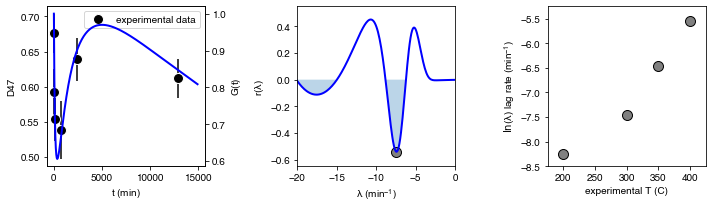

In [10]:
#import functions
from isotopylog.calc_funcs import (_calc_A, _Gaussian)

#set constants
exp = 39
omega = 0.1

#define he stylistic dictionary
ed = {'fmt':'o', 'mec':'w','mfc':'k','ms':10,'ecolor':'k'}

#import data
df = dftot.xs(exp, level = 'exp', drop_level = True).reset_index()
he = ipl.HeatingExperiment.from_csv(df)

#make nu array
nu_min = -20
nu_max = 10
nnu = 300
nu = np.linspace(nu_min, nu_max, nnu)

#make time array
t = np.linspace(0,1.5e4,300)

# find best-fit solution that includes negative mass
rho_nu, omega, res_inv, rgh_inv = ipl.fit_HH20inv(
    he,
    nu_min = nu_min,
    nu_max = nu_max,
    nnu = nnu,
    non_neg = False, 
    omega = omega,
    )

#forward-model G evolution
A = _calc_A(t,nu)
G = np.dot(A,rho_nu)

#make plot
fig6, ax6 = plt.subplots(1,3,
    figsize = (10,3)
    )

# Panel A: G(t) evolution

#plot data
he.plot(ax = ax6[0], ed = ed)

#twinx and plot predicted G(t) evolution
axt = ax6[0].twinx()
axt.plot(
    t,
    G,
    linewidth = 2,
    color = 'b'
    )

#set labels and limits
ax6[0].set_xlabel(r'$t$ (min)')
axt.set_ylabel(r'$G(t)$')

# Panel B: r(lam) distribution
ax6[1].plot(
    nu,
    rho_nu,
    linewidth = 2,
    color = 'b'
    )

#add shading
ax6[1].fill_between(
    nu,
    rho_nu,
    0,
    where = rho_nu <= 0,
    alpha = 0.3)

#add point at minimum
ind = np.where(rho_nu == np.min(rho_nu))
ax6[1].scatter(nu[ind], rho_nu[ind],
    color = [0.5,0.5,0.5],
    edgecolor = 'k',
    s = 100,
    )

#set labels and limits
ax6[1].set_xlim([-20,0])
ax6[1].set_ylim([-0.65,0.55])
ax6[1].set_xlabel(r'$\lambda$ (min$^{-1}$)')
ax6[1].set_ylabel(r'$r(\lambda)$')

# Panel C: rho(lam) min point vs. T

#nu values for minimum of rho(nu) for experiments at various temperatures
Tvr = np.array([[200, -8.261],
                 [300, -7.458],
                 [350, -6.455],
                 [400, -5.551]])

ax6[2].scatter(Tvr[:,0], Tvr[:,1],
    s = 100,
    color = [0.5,0.5,0.5],
    edgecolor = 'k',
    )

#set limits and labels
ax6[2].set_xlim([175,425])
ax6[2].set_ylim([-8.5,-5.25])

ax6[2].set_xlabel(r'experimental T (C)')
ax6[2].set_ylabel(r'$\ln(\lambda)$ lag rate ($min^{-1}$)')

plt.tight_layout()

# Save figure
fig6.savefig('output_figures/Fig_6.pdf',
    transparent = True,
    bbox_inches = None,
    )

### Figure 7

Example model fit comparison for an optical calcite (MBG-CC-1) heating experiment performed at 425 C showing (\textbf{A}) measured and predicted $\Delta_{47}$ evolution trends and (\textbf{B}) predicted vs. measured $\Delta_{47}$ evolution misfit for each model (data from Passey and Henkes 2012). Fit statistics for each model are as follows: transient defect/equilibrium defect model (orange; Henkes et al. 2014), log$_{10}$ rmse = $-1.94$; pair-diffusion model (red; Stolper and Eiler, 2015), log$_{10}$ rmse = $-1.92$; lognormal disordered kinetic model (blue; this study), log$_{10}$ rmse = $-2.06$.

He14 model log_10 rmse: -1.94
SE15 model log_10 rmse: -1.92
HH20 model log_10 rmse: -2.06


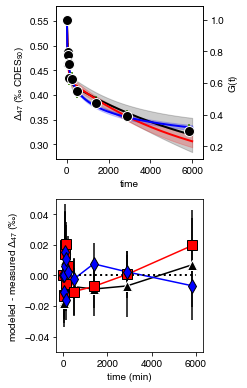

In [11]:
from scipy.interpolate import interp1d

#make figure
fig7, ax7 = plt.subplots(2,1,
    figsize = (3.54, 5.5)
    )

# PANEL A: PREDICTIONS

#comparison of fits for each model for MBG-CC-1 at 425 C
exp_nr = 3

#extract data
df = dftot.xs(exp_nr, level = 'exp', drop_level = True).reset_index()

#fit model:
#make heatingexperiment object
he = ipl.HeatingExperiment.from_csv(
    df, 
    culled = False #culled manually above, if necessary
    )

#Hea14 model fit
kd_Hea14 = ipl.kDistribution.invert_experiment(
    he,
    'Hea14',
    p0 = [-7, -7, -7],
    )

#SE15 model fit
kd_SE15 = ipl.kDistribution.invert_experiment(
    he,
    'SE15'
    )

#HH20 lognormal model fit
kd_HH20 = ipl.kDistribution.invert_experiment(
    he,
    'HH20',
    fit_reg = False
    )

he.forward_model(kd_Hea14)
print('He14 model log_10 rmse: %.2f' % np.log10(kd_Hea14.rmse))

he.plot(
    ax = ax7[0],
    ed = {'fmt':'o', 'mec':'w','mfc':'k','ms':10,'ecolor':'k'}, #errorbar style
    ld = {'linewidth':2,'color':'k'}, #line style
    fbd = {'alpha':0.2,'color':'k'}, #fill between style
    )

he.forward_model(kd_SE15)
print('SE15 model log_10 rmse: %.2f' % np.log10(kd_SE15.rmse))

he.plot(
    ax = ax7[0],
    ed = {'fmt':'none'}, #errorbar style
    ld = {'linewidth':2,'color':'r'}, #line style
    fbd = {'alpha':0.2,'color':'r'}, #fill between style
    )
    
he.forward_model(kd_HH20)
print('HH20 model log_10 rmse: %.2f' % np.log10(kd_HH20.rmse))

he.plot(
    ax = ax7[0],
    ed = {'fmt':'none'}, #errorbar style
    ld = {'linewidth':2,'color':'b'}, #line style
    fbd = {'alpha':0.2,'color':'b'}, #fill between style
    )

ax7[0].get_legend().remove()

#set limits and labels
ax7[0].set_xlim([-500,6500])
ax7[0].set_ylim([0.27,0.58])
ax7[0].set_ylabel(r'$\Delta_{47}$ (‰ CDES$_{90}$)')

#twinx plot to add G axis:
#extract limits
ylim = np.array(ax7[0].get_ylim())
Deq = he.caleq(he.T)
D0 = he.dex[0,0]

#convert limits to G limits and plot
glim = (ylim - Deq)/(D0-Deq)
axt = ax7[0].twinx()
axt.set_ylim(glim)

#define labels
axt.set_ylabel(r'$G(t)$')

# PANEL B: MODEL-DATA MISFITS

#make list of model types
mods = [kd_Hea14, kd_SE15, kd_HH20]

#make list of plotting styles
ed_Hea14 = {'fmt':'^', 'mec':'w','mfc':'k','ms':10,'ecolor':'k'}
ed_SE15 = {'fmt':'s', 'mec':'k','mfc':'r','ms':10,'ecolor':'k'}
ed_HH20 = {'fmt':'d', 'mec':'k','mfc':'b','ms':10,'ecolor':'k'}
styles = [ed_Hea14, ed_SE15, ed_HH20]

#loop through each model type and plot
for i, mod in enumerate(mods):

    #forward-model a given kdistribution model
    he.forward_model(mod)

    #interpolate onto experimental time points
    fD = interp1d(he.t, he.D)
    fD_std = interp1d(he.t, he.D_std)

    #calculate model - measured difference, including propagated error
    Dp = fD(he.tex)
    Dp_std = fD_std(he.tex)

    Dm = he.dex[:,0]
    Dm_std = he.dex_std[:,0]

    DD = Dm - Dp
    DD_std = np.sqrt(Dm_std**2 + Dp_std**2)

    #plot results
    ax7[1].plot(he.tex, DD, c = styles[i]['mfc'])
    ax7[1].errorbar(
        he.tex, 
        DD, 
        yerr = DD_std, 
        **styles[i]
        )

#add line at zero
ax7[1].plot([0,6000],[0,0],':k',linewidth = 2)

#set labels and limits
ax7[1].set_ylim([-0.05, 0.05])
ax7[1].set_ylabel(r'modeled - measured $\Delta_{47}$ (‰)')
ax7[1].set_xlabel(r'time (min)')

plt.tight_layout()
plt.show()

# Save figure
fig7.savefig('output_figures/Fig_7.pdf',
    transparent = True,
    bbox_inches = None,
    )

### Figure 8

Isotopologue reordering diagnostic plots. (\textbf{A}) Apparent equilibrium temperature, $T(\Delta_{47})_{\text{ae}}$, for a variety of cooling rates. To generate each line, $\Delta_{47}$ is initially in equilibrium at an arbitrarily high temperature, which then decreases linearly at a given rate. $T(\Delta_{47})_{\text{ae}}$ at each cooling rate is determined using the calculated apparent equilibrium $\Delta_{47}$ value for that rate. (\textbf{B}) Time-temperature fields for $\Delta_{47}$ preservation. To generate each line, material that is initially described by $T(\Delta_{47}) = 25$ C is assumed to be instantaneously heated and held at a given temperature; dotted lines indicate the time until incipient ($1\%$) isotopologue reordering, which is conservative and may be below the detection limit given typical precision on natural samples, whereas solid lines indicate the time until complete ($99\%$) isotopologue reordering at that temperature. Colors indicate predictions using the kinetic values for each model as reported in their original publications: blue = transient defect/equilibrium defect (Henkes et al., 2014), orange = paired reaction-diffusion (Stolper and Eiler, 2015), black =  dolomite lognormal disordered kinetics (this study), red =  calcite lognormal disordered kinetics (this study). Shading in \textbf{A} represents model parameter $\pm 1 \sigma$ uncertainty.

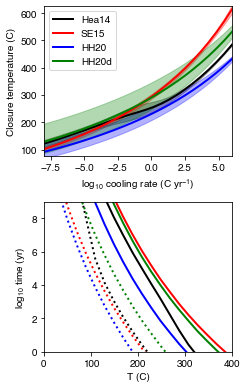

In [12]:
#make figure
fig8, ax8 = plt.subplots(2,1,
    figsize = (3.54, 5.5)
    )

# PANEL A: COOLING RATE VS. CLOSURE TEMP

#set constants
nlcr = 25 #number of cooling rates to iterate over
nt = 1000 #number of time points to iterate over

# #coarse resolution for testing
# nlcr = 10 #number of cooling rates to iterate over
# nt = 100 #number of time points to iterate over

#make array of log cooling rates
lcr_min = -8 # K/year
lcr_max = 6

lcr_vec = np.linspace(lcr_min, lcr_max, nlcr)
spy = 60*60*24*365 #seconds per year
cr_vec = (10**lcr_vec)/spy # K/s

#set initial and final "actual" temperature
T0 = 1000 + 273.15 #K
Tf = 0 + 273.15 #K

#set initial D47 in equilibrium
D0 = ipl.Deq_from_T(T0)
D0_std = 0.010

d0 = [D0, 0, 0]
d0_std = [D0_std, 0, 0]

#make list of models
# NOTE: DEFAULTS TO UNITS OF SECONDS AND KELVIN!
mods = ['Hea14','SE15','HH20','HH20d']

#make list of model colors and shapes for plotting
cs = ['k', 'r', 'b','g']
fmts = ['^','s','d','o']

#pre-allocate results dataframe
cols = [m + '_cl' for m in mods] + [m + '_lb' for m in mods] + [m + '_ub' for m in mods]
cr_res = pd.DataFrame(
    index = lcr_vec, 
    columns = cols,
    dtype = float,
    )

#loop through each cooling rate and each model and store in results dataframe
for i, cr in enumerate(cr_vec):
    
    #calculate time array, in seconds, and T array, in Kelvin
    t0 = 0
    tf = (T0-Tf)/cr #seconds

    t = np.linspace(t0, tf, nt)
    T = np.linspace(T0, Tf, nt)
    
    #loop through models and calculate
    for j, mod in enumerate(mods):
        
        #deal with strings for dolomite
        if mod == 'HH20d':
            mo = 'HH20'
            mi = 'dolomite'
        
        else:
            mo = mod
            mi = 'calcite'

        #calculate ed from literature
        ed = ipl.EDistribution.from_literature(
            mineral = mi,
            reference = mo,
            )

        #calculate D at each time step
        D, Dstd = ipl.geologic_history(
            t, 
            T, 
            ed, 
            d0, 
            d0_std = d0_std,
            )

        #calculate apparent temperature
        Tapp = ipl.T_from_Deq(D)
        
        #calculate closure temp, including uncertainty, and store
        cr_res.iloc[i][mod + '_cl'] = Tapp[-1]
        cr_res.iloc[i][mod + '_lb'] = ipl.T_from_Deq(D[-1] + Dstd[-1])
        cr_res.iloc[i][mod + '_ub'] = ipl.T_from_Deq(D[-1] - Dstd[-1])

#plot results
for j, mod in enumerate(mods):
    
    #plot mean values
    ax8[0].plot(
        lcr_vec, 
        cr_res[mod + '_cl'] - 273.15,
        label = mod,
        c = cs[j],
        linewidth = 2,
        )
    
    #shade between uncertainty
    ax8[0].fill_between(
        lcr_vec, 
        cr_res[mod + '_lb'] - 273, 
        cr_res[mod + '_ub'] - 273, 
        alpha = 0.3,
        color = cs[j]
        )
    
#set limits, labels, and legend
ax8[0].set_xlim([lcr_min, lcr_max])
ax8[0].set_ylim([75, 625])

ax8[0].set_xlabel(r'$log_{10}$ cooling rate (C $yr^{-1}$)')
ax8[0].set_ylabel(r'Closure temperature (C)')

ax8[0].legend(loc = 'best')

# PANEL B: INCIPIENT AND COMPLETE REORDERING FOR "BOXCAR" HEATING

#set constants
nT = 50
nt = 1000

#coarse resolution for testing
# nT = 10
# nt = 100

incip_frac = 0.01
comp_frac = 0.99

#make t array
lt_min = -11 #log10 years min time
lt_max = 11 #log10 years max time

lt_vec = np.linspace(lt_min, lt_max, nt)
spy = 60*60*24*365 #seconds per year
ts = (10**lt_vec)*spy

#make T array
# T_min = 30 #C
# T_max = 250

T_min = 30 #C
T_max = 1000

T_vec = np.linspace(T_min, T_max, nT) + 273.15

#set initial D47 in equilibrium
T0_eq = 25 + 273.15 #assume starting in equilibrium at 25C
D0 = ipl.Deq_from_T(T0_eq)
D0_std = 0.010

d0 = [D0, 0, 0]
d0_std = [D0_std, 0, 0]

#pre-allocate results dataframe
cols = [m + '_incip_yr' for m in mods] + [m + '_comp_yr' for m in mods]
rt_res = pd.DataFrame(
    index = T_vec, 
    columns = cols,
    dtype = float,
    )

#loop through each temperature and each model and store results in dataframe
for i, T in enumerate(T_vec):
    
    #make vector of length nt at T
    Ts = np.ones(nt)*T
    
    #calculate equilibrium D47 at T
    Deq = ipl.Deq_from_T(T)
    
    #loop through models and calculate
    for j, mod in enumerate(mods):
        
        #deal with strings for dolomite
        if mod == 'HH20d':
            mo = 'HH20'
            mi = 'dolomite'
        
        else:
            mo = mod
            mi = 'calcite'

        #calculate ed from literature
        ed = ipl.EDistribution.from_literature(
            mineral = mi,
            reference = mo,
            )

        #calculate D at each time step
        D, Dstd = ipl.geologic_history(
            ts, 
            Ts, 
            ed, 
            d0, 
            d0_std = d0_std,
            )
        
        #calculate array of fraction reset
        f_reset = 1 - (D - Deq)/(D0 - Deq)
        
        #find first instance where f_reset > 0.01 and f_reset > 0.99
        # set as nan if D never gets that reset
        try:
            ii = np.where(f_reset >= incip_frac)[0][0]
            lti = lt_vec[ii]
        
        except IndexError:
            lti = np.nan
        
        try:
            ci = np.where(f_reset >= comp_frac)[0][0]
            ltc = lt_vec[ci]
        
        except IndexError:
            ltc = np.nan
        
        #store results
        rt_res.iloc[i][mod + '_incip_yr'] = lti
        rt_res.iloc[i][mod + '_comp_yr'] = ltc

#plot results
for j, mod in enumerate(mods):
    
    ax8[1].plot(
        T_vec - 273.15,
        rt_res[mod+'_incip_yr'],
        ':',
        linewidth = 2,
        color = cs[j],
        )
    
    ax8[1].plot(
        T_vec - 273.15,
        rt_res[mod+'_comp_yr'],
        linewidth = 2,
        color = cs[j],
        )

# ax8[1].set_xlim([25, 250])
# ax8[1].set_ylim([6,9])

ax8[1].set_xlim([0, 400])
ax8[1].set_ylim([0,9])

ax8[1].set_xlabel('T (C)')
ax8[1].set_ylabel(r'$log_{10}$ time (yr)')


plt.tight_layout()
plt.show()

#save figure
fig8.savefig('output_figures/Fig_8.pdf',
    transparent = True,
    bbox_inches = None,
    )

## Figure 9

Thermal histories and corresponding model-predicted carbonate $T(\Delta_{47})$ evolution for two geologic examples from the recent literature: (\textbf{A}--\textbf{B}) a 1D conductive cooling model of the Amba Dongar carbonatite (Fosu et al. 2020, cooling model adapted from Ehlers (2005) for a 550 C intrusion 1.9 km in diameter that cools by thermal diffusion with 30 C country rock with a diffusivity of 38 km$^2$ Ma$^{-1}$, and (\textbf{C}--\textbf{D}) modeled thermal history for various sample depths of the Wagon Wheel 1 (WW-1) drill core in the northwestern Green River Basin (LaCroix and Niemi, 2019). Panels \textbf{A} and \textbf{C} show imposed $t$--$T$ histories (color-coded by WW-1 core depth in \textbf{C}) whereas panels \textbf{B} and \textbf{D} show reordering model-predicted $T(\Delta_{47})$ plotted against imposed model $T$. All models in \textbf{B} predict closure temperature-like behavior, whereas the $T$--$T$ pathways predicted by the disordered kinetic model in \textbf{D} are more complex and exhibit three distinctive features: (i) the temperature of incipient isotopologue bond reordering, (ii) the rate of approach to equilibrium (shown as a dotted $1:1$ line), and (iii) the final $T(\Delta_{47})_{\text{ae}}$ (shown to the left of the $y$-axis, including $\pm 1\sigma$ model uncertainty). Colors in \textbf{B} indicate predictions using the kinetic values for each model as reported in their original publications. Published $T(\Delta_{47})$ values for each geologic scenario are shown shown as: small gray circles = non-replicated measurements from Amba Dongar (population mean and median as large white circle and red line, respectively; Fosu et al. 2020); large grayscale circles = WW-1 measurements color-coded by core depth, including $\pm1$ s.e. measurement uncertainty.

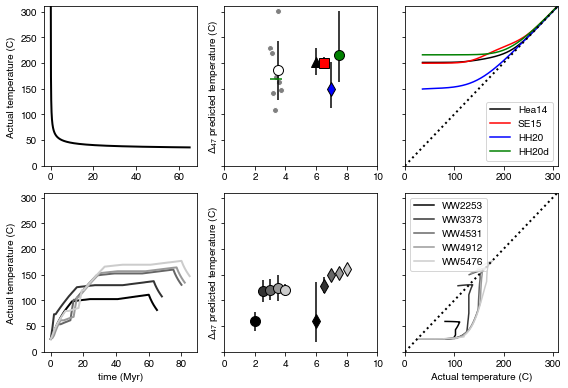

In [13]:
#set input variables
# ni = 1000 #for interpolating diffusive cooling history to high-res t
D0_std = 0.010

#import carbonatite cooling data
vc = pd.read_csv('cooling_volc.csv')
fosu = pd.read_csv('Fosu_2020_data.csv', index_col = 0)

#import sedimentary heating data
wwh = pd.read_csv('WagonWheel_heating.csv', header = [0,1])
lacroix = pd.read_csv('LaCroix_2019_data.csv', index_col = 0)

#make list of models for carbonatite cooling plot
# NOTE: DEFAULTS TO UNITS OF SECONDS AND KELVIN!
mods = ['Hea14','SE15','HH20','HH20d']

#make list of model colors and shapes for plotting
cs = ['k', 'r', 'b','g']
fmts = ['^','s','d','o']

#make figure
fig9, ax9 = plt.subplots(
    2,
    3,
    figsize = (8, 5.5),
    sharey = True
    )

# TOP ROW: CARBONATITE COOLING

#get time in seconds and T in kelvin
t = (vc['t_Myr']*1e6*365*24*60*60).values
T = (vc['T_C'] + 273.15).values

# PANEL A
#plot T-T history
ax9[0,0].plot(vc['t_Myr'], vc['T_C'],
    linewidth = 2,
    color = 'k',
    )

# PANEL B
#plot measured data from Fosu et al. 2020
nsam = len(fosu)
x = np.arange(0,nsam)/10 + 3

#get individual data points
TDeq = fosu['TDeq'] + 273.15

#plot
ax9[0,1].errorbar(x, TDeq - 273.15,
    yerr = 0,
    fmt = 'o',
    mec = 'w',
    mfc = [0.5,0.5,0.5],
    ms = 6,
    ecolor = 'k',
    )

ax9[0,1].scatter(x.mean(), TDeq.median() - 273.15,
    marker = '_',
    c = 'g',
    zorder = 15,
    s = 125
    )

#get population mean and std. dev
TDeq_mu = np.mean(TDeq)
TDeq_std = np.std(TDeq)

#plot
ax9[0,1].errorbar(3.5, TDeq_mu - 273.15,
    yerr = TDeq_std,
    fmt = 'o',
    mec = 'k',
    mfc = 'w',
    ms = 10,
    ecolor = 'k',
    zorder = 10,
    )

#PANEL C
#plot modeled data

#input initial isotope composition
T0 = T[0]
D0 = ipl.Deq_from_T(T0)
d0 = [D0, 0, 0]
d0_std = [D0_std, 0, 0]

for j, mod in enumerate(mods):

    #deal with strings for dolomite
    if mod == 'HH20d':
        mo = 'HH20'
        mi = 'dolomite'

    else:
        mo = mod
        mi = 'calcite'

    #calculate ed from literature
    ed = ipl.EDistribution.from_literature(
        mineral = mi,
        reference = mo,
        )

    #calculate D at each time step
    D, Dstd = ipl.geologic_history(
        t, 
        T, 
        ed, 
        d0, 
        d0_std = d0_std,
        )

    #calculate apparent temperature
    Tapp = ipl.T_from_Deq(D)

    #calculate closure temp including uncertainty
    Tcl = Tapp[-1]
    Tcl_lb = ipl.T_from_Deq(D[-1] - Dstd[-1])
    Tcl_ub = ipl.T_from_Deq(D[-1] + Dstd[-1])

    yerr = np.array([Tcl - Tcl_lb, Tcl_ub - Tcl])
    yerr = yerr.reshape(2,1)

    #plot T trajectories
    ax9[0,2].plot(
        T - 273.15, 
        Tapp - 273.15,
        label = mod,
        c = cs[j]
        )

    #plot closure temps
    ax9[0,1].errorbar(
        6+j/2,
        Tcl - 273.15,
        yerr = yerr,
        fmt = fmts[j],
        mec = 'k',
        mfc = cs[j],
        ms = 10,
        ecolor = 'k',
        )

#add 1:1 line
ax9[0,2].plot(
    [0,500],
    [0,500],
    ':k',
    linewidth = 2,
    )

# BOTTOM ROW: SEDIMENTARY HEATING

#get sample names
sams = wwh.columns.levels[0]

#loop through each sample
for i, sam in enumerate(sams):
    
    #extract data
    T_C = wwh[sam]['T_C'].dropna()
    t_Myr = wwh[sam]['t_Myr'].dropna()

    
    #sort time so that 0 is formation time (not modern as reported in Lacroix)
    t_Myr = -t_Myr + np.max(t_Myr)    
    T_C = T_C[::-1]
    t_Myr = t_Myr[::-1]
    
    #convert to seconds and kelvin
    t = (t_Myr*1e6*365*24*60*60).values
    T = (T_C + 273.15).values
    
    # PANEL D
    #plot T-T histories
    ax9[1,0].plot(t_Myr, T_C,
        linewidth = 2,
        color = [i/5, i/5, i/5],
        )

    # PANEL E
    #plot measured data from LaCroix 2020
    TDeq = lacroix.loc[sam,'TDeq'] + 273.15
    TDeq_std = lacroix.loc[sam,'TDeq_std']
    
    #plot
    ax9[1,1].errorbar(2+i/2, TDeq - 273.15,
        yerr = TDeq_std,
        fmt = 'o',
        mec = 'k',
        mfc = [i/5, i/5, i/5],
        ms = 10,
        ecolor = 'k',
        )
    
    # PANEL F
    
    #input initial isotope composition
    T0 = T[0]
    D0 = ipl.Deq_from_T(T0)
    d0 = [D0, 0, 0]
    d0_std = [D0_std, 0, 0]
    
    #calculate ed from literature for each sample t-T trajectory
    ed = ipl.EDistribution.from_literature(
        mineral = 'calcite',
        reference = 'HH20',
        )

    #calculate D at each time step
    D, Dstd = ipl.geologic_history(
        t, 
        T, 
        ed, 
        d0, 
        d0_std = d0_std,
        )

    #calculate apparent temperature
    Tapp = ipl.T_from_Deq(D)

    #calculate closure temp including uncertainty
    Tcl = Tapp[-1]
    Tcl_lb = ipl.T_from_Deq(D[-1] - Dstd[-1])
    Tcl_ub = ipl.T_from_Deq(D[-1] + Dstd[-1])

    yerr = np.array([Tcl - Tcl_lb, Tcl_ub - Tcl])
    yerr = yerr.reshape(2,1)

    #plot T trajectories
    ax9[1,2].plot(
        T - 273.15, 
        Tapp - 273.15,
        label = sam,
        c = [i/5, i/5, i/5],
        )

    #plot closure temps
    ax9[1,1].errorbar(
        6+i/2,
        Tcl - 273.15,
        yerr = yerr,
        fmt = fmts[2],
        mec = 'k',
        mfc = [i/5, i/5, i/5],
        ms = 10,
        ecolor = 'k',
        )

#add 1:1 line
ax9[1,2].plot(
    [0,500],
    [0,500],
    ':k',
    linewidth = 2,
    )

#set limits and labels
ax9[0,0].set_ylim([0,310])
ax9[0,2].set_xlim([0,310])
ax9[1,2].set_xlim([0,310])

ax9[0,1].set_xlim([0,10])
ax9[1,1].set_xlim([0,10])

#set labels
ax9[0,0].set_ylabel(r'Actual temperature (C)')
ax9[1,0].set_ylabel(r'Actual temperature (C)')

ax9[0,1].set_ylabel(r'$\Delta_{47}$ predicted temperature (C)')
ax9[1,1].set_ylabel(r'$\Delta_{47}$ predicted temperature (C)')

ax9[1,2].set_xlabel(r'Actual temperature (C)')
ax9[1,0].set_xlabel('time (Myr)')

#add legends
ax9[0,2].legend(loc = 'best')
ax9[1,2].legend(loc = 'best')

plt.tight_layout()
plt.show()

# Save figure
fig9.savefig('output_figures/Fig_9.pdf',
    transparent = True,
    bbox_inches = None,
    )

### Figure S.1

Example demonstrating that the Henkes et al. (2014) model is consistent with disordered kinetics. Henkes et al. (2014) $k$ values for the model fit to an optical calcite (MBG-CC-1) isotopologue reordering experiment at 425 C (symbols in \textbf{A}; in Henkes et al. (2014) notation; data from their Table B2) were used to generate a $\Delta_{47}$ evolution trajectory (dotted black line in \textbf{B}). The inverse Laplace transform was then determined from this trajectory, leading to the pdf of $\nu$ in \textbf{A} and the corresponding forward-modeled $\Delta_{47}$ trajectory in \textbf{B} (solid blue lines). Both $\Delta_{47}$ trajectories are identical, demonstrating that the Henkes et al. (2014) model is perfectly recreated by disordered kinetics. For reference, reaction progress is also shown by converting $\Delta_{47}$ to $G(t)$.

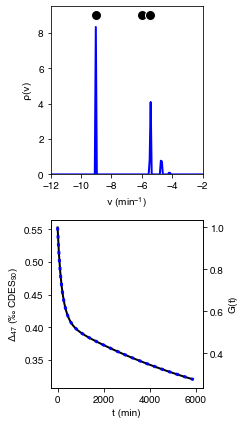

In [14]:
#define Henkes et al. 2014 model inputs
#in the order: lnkc, lnkd, lnk2 (in Hea14 notation; min-1)
lnkH = np.array([-9.03, -6.00, -5.46])
kH = np.exp(lnkH)

#set constants
exp = 3 # for MBG-CC-1 425C experiment
nt = 100
nu_min = -20
nu_max = 0

#create "true" D47 and G(t) evolution using these input parameters:
#extract experimental data
df = dftot.xs(exp, level='exp', drop_level = True).reset_index()

#make temperature array
tmax = df['t_min'].values[-1]
tex = np.linspace(0, tmax, nt)

#make "true" G and D arrays (Hea14 Eq. 5)
G = np.exp(-kH[0]*tex + (kH[1]/kH[2])*(np.exp(-kH[2]*tex) - 1))

D0 = df['D47'].values[0]
T = float(df['T_C'].values[0] + 273.15)
Deq = ipl.Deq_from_T(T)
D = G*(D0 - Deq)+Deq

#make he object with "true" data
dex = np.zeros([nt,3]) #get into isoclump input format
dex[:,0] = D
dex_std = np.zeros([nt,3]) + 0.0001

he = ipl.HeatingExperiment(
    dex, 
    T, 
    tex, 
    dex_std = dex_std
    )

#fit with HH20 model
kd = ipl.kDistribution.invert_experiment(
    he,
    model = 'HH20', #for the model presented in this paper
    fit_reg = True,
    nu_min = nu_min,
    nu_max = nu_max,
    omega = 0,
    )

#forward model
he.forward_model(kd)

#make plot
figS1, axS1 = plt.subplots(2,1,
    figsize = (3.54, 6)
    )

# Panel A: rho(nu) distributions

#plot inversion data
axS1[0].plot(
    kd.nu,
    kd.rho_nu_inv,
    linewidth = 2,
    c = 'b'
    )

#plot Henkes data as scatter
axS1[0].scatter(
    lnkH,
    np.ones(3)*9,
    s = 100,
    edgecolor = 'w',
    facecolor = 'k',
    )

#set limits and labels
axS1[0].set_xlim([-12,-2])
axS1[0].set_ylim([0,9.5])
axS1[0].set_xlabel(r'$\nu$ (min$^{-1}$)')
axS1[0].set_ylabel(r'$\rho(\nu)$')

# Panel B: D and G vs. t
#"true" data
axS1[1].plot(
    tex,
    D,
    c = 'k',
    linewidth = 2
    )

#disordered kinetic model data
axS1[1].plot(
    he.t, 
    he._Dinv,
    ls = ':',
    c = 'b',
    linewidth = 3)

#convert limits to G limits and plot
ylim = np.array(axS1[1].get_ylim())
glim = (ylim - Deq)/(D0-Deq)
axt = axS1[1].twinx()
axt.set_ylim(glim)

#duplicate and make G axis
axS1[1].set_xlabel('t (min)')
axS1[1].set_ylabel(r'$\Delta_{47}$ (‰ CDES$_{90}$)')
axt.set_ylabel(r'$G(t)$')

plt.tight_layout()

# Save figure
figS1.savefig('output_figures/Fig_S1.pdf',
    transparent = True,
    bbox_inches = None,
    )

### Figure S.4

Time-temperature fields for $\Delta_{47}$ preservation. Same as Fig. 5B, but calculated here for individual calcite minerals: (\textbf{A}) MGB-CC-1 optical calcite (data from Passey and Henkes, 2012), (\textbf{B}) NE-CC-1 spar calcite (data from Passey and Henkes, 2012), (\textbf{C}) Mexican optical calcite (data from Stolper and Eiler, 2015), (\textbf{D}) WA-CB-13 brachiopod shell calcite (data from Henkes et al., 2014). To generate each line, material that is initially described by $T(\Delta_{47}) = 25$ C is assumed to be instantaneously heated and held at a given temperature; dotted lines indicate the time until incipient ($1\%$) isotopologue reordering, which is conservative and may be below the detection limit given typical precision on natural samples, whereas solid lines indicate the time until complete ($99\%$) isotopologue reordering at that temperature. Where available, predictions were generated using kinetic values for each model as reported in their original publications (Henkes et al., 2014; Stolper and Eiler, 2015). In some cases, model parameters for certain minerals have not been previously reported (transient defect/equilibrium defect: NE-CC-1, Mexican optical calcite; paired reaction-diffusion: NE-CC-1) and were calculated here by fitting the original heating experiment data using the 'isotopolog' python package (Hemingway, 2020). blue = transient defect/equilibrium defect (Henkes et al., 2014), orange = paired reaction-diffusion (Stolper and Eiler, 2015), black = lognormal disordered kinetics, hydrothermal conditions (this study; sample MGB-CC-1 only; data from Brenner et al., 2018), red =  lognormal disordered kinetics (this study).

working on sample: WA-CB-13
working on model: Hea14
working on model: SE15
working on model: HH20
working on sample: NE-CC-1
working on model: Hea14
working on model: SE15
working on model: HH20
working on sample: MGB-CC-1_WP
working on model: HH20
working on sample: MOC
working on model: Hea14


/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


working on model: SE15
working on model: HH20
working on sample: MGB-CC-1
working on model: Hea14
working on model: SE15
working on model: HH20


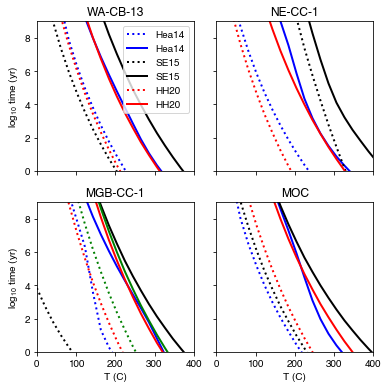

In [15]:
# INCIPIENT AND COMPLETE REORDERING FOR "BOXCAR" HEATING SEPARATED BY SAMPLE TYPE

#import mineral- and model-speific decay rates
sm_rates = pd.read_csv('sample_specific_eds.csv', index_col = 0)
sams = list(set(sm_rates.index))

#list of low-pressure experiments for indexing purposes
slp = ['WA-CB-13', 'NE-CC-1', 'MGB-CC-1', 'MOC']

# #set constants
nT = 50
nt = 1000

#coarse resolution for testing
# nT = 10
# nt = 100

incip_frac = 0.01
comp_frac = 0.99

mods = ['Hea14','SE15','HH20']

#make figure
figS4, axS4 = plt.subplots(2,2,
    sharex = True,
    sharey = True,
    figsize = (5.5,5.5)
    )

#make flattened list for looping purposes
axf = axS4.flatten()

#make list of model colors and shapes for plotting
cs = ['b', 'k', 'r', 'g']

#make t array
lt_min = -11 #log10 years min time
lt_max = 11 #log10 years max time

lt_vec = np.linspace(lt_min, lt_max, nt)
spy = 60*60*24*365 #seconds per year
ts = (10**lt_vec)*spy

#make T array
T_min = 0 #C
T_max = 1000

T_vec = np.linspace(T_min, T_max, nT) + 273.15

#set initial D47 in equilibrium
T0_eq = 25 + 273.15 #assume starting in equilibrium at 25C
D0 = ipl.Deq_from_T(T0_eq)
D0_std = 0.010

d0 = [D0, 0, 0]
d0_std = [D0_std, 0, 0]

#pre-allocate results dataframe
inc = [m + '_incip_yr_' + s for m in mods for s in slp]
com = [m + '_comp_yr_' + s for m in mods for s in slp]
cols = inc + com

#add HH20 hydrothermal
cols.append('HH20_incip_yr_MGB-CC-1_WP')
cols.append('HH20_comp_yr_MGB-CC-1_WP')

rt_res = pd.DataFrame(
    index = T_vec, 
    columns = cols,
    dtype = float,
    )

#loop through each sample and each model and solve
for i, s in enumerate(sams):
    print('working on sample: %s' %s)
    
    for j, m in enumerate(mods):
        
        if s == 'MGB-CC-1_WP' and m != 'HH20':
            continue
        
        print('working on model: %s' %m)
        
        #extract rate results for a given model+sample pair
        s_rates = sm_rates.loc[s]
        r = s_rates[s_rates['model'] == m]
        r = r.dropna(axis=1) #drop p3 and s3 for HH20 model

        #loop through and make list of kd objects
        kds = []

        for i, row in r.iterrows():
            #extracts parameters and uncertainty
            params = row.filter(regex=('p.*')).astype(float)
            params_std = row.filter(regex=('s.*')).astype(float)

            #calculate kd object and append to list
            kd = ipl.kDistribution(
                params,
                m,
                row['T'] + 273.15,
                params_cov = np.diag(params_std**2)
                )

            kds.append(kd)

        #make EDistribution
        ed = ipl.EDistribution(kds)
        
        #loop through each temperature and store results in dataframe
        for k, T in enumerate(T_vec):
            
            #make vector of length nt at T
            Ts = np.ones(nt)*T

            #calculate equilibrium D47 at T
            Deq = ipl.Deq_from_T(T)
            
            #calculate D at each time step
            D, Dstd = ipl.geologic_history(
                ts, 
                Ts, 
                ed, 
                d0, 
                d0_std = d0_std,
                )

            #calculate array of fraction reset
            f_reset = 1 - (D - Deq)/(D0 - Deq)

            #find first instance where f_reset > 0.01 and f_reset > 0.99
            # set as nan if D never gets that reset
            try:
                ii = np.where(f_reset >= incip_frac)[0][0]
                lti = lt_vec[ii]

            except IndexError:
                lti = np.nan

            try:
                ci = np.where(f_reset >= comp_frac)[0][0]
                ltc = lt_vec[ci]

            except IndexError:
                ltc = np.nan

            #store results
            rt_res.iloc[k][m + '_incip_yr_' + s] = lti
            rt_res.iloc[k][m + '_comp_yr_' + s] = ltc

#plot results!
for i, s in enumerate(slp):
    for j, m in enumerate(mods):

        #plot incip lines
        axf[i].plot(
            T_vec - 273.15,
            rt_res[m + '_incip_yr_' + s],
            ':',
            linewidth = 2,
            color = cs[j],
            label = m
            )

        #plot final lines
        axf[i].plot(
            T_vec - 273.15,
            rt_res[m + '_comp_yr_' + s],
            linewidth = 2,
            color = cs[j],
            label = m
            )
        
        #check if MGB-CC-1 and add HH20 hydrothermal
        if s == 'MGB-CC-1' and m == 'HH20':
            #plot incip lines
            axf[i].plot(
                T_vec - 273.15,
                rt_res[m + '_incip_yr_' + s + '_WP'],
                ':',
                linewidth = 2,
                color = cs[3],
                )

            #plot final lines
            axf[i].plot(
                T_vec - 273.15,
                rt_res[m + '_comp_yr_' + s + '_WP'],
                linewidth = 2,
                color = cs[3],
                label = 'HH20_WP'
                )
        
        
        #set title
        axf[i].set_title(s)

#set limits and labels
axf[0].legend(loc = 'best')

axf[0].set_xlim([0,400])
axf[0].set_ylim([0,9])

axf[2].set_xlabel('T (C)')
axf[3].set_xlabel('T (C)')

axf[0].set_ylabel(r'$log_{10}$ time (yr)')
axf[2].set_ylabel(r'$log_{10}$ time (yr)')

plt.tight_layout()
plt.show()

# Save figure
figS4.savefig('output_figures/Fig_S4.pdf',
    transparent = True,
    bbox_inches = None,
    )